# Test simulation matching

## Imports

In [1]:
import sys
import os
import pprint
import cPickle as pickle
import numpy as np
from matplotlib import pyplot as plt
gleam_root = "/Users/phdenzel/gleam"
sys.path.append(gleam_root)
from gleam.reconsrc import ReconSrc, run_model
from gleam.utils.plotting import plot_scalebar, plot_labelbox
# from gleam.utils.plotting import IPColorbar, IPPointCache
import gleam.utils.colors as gcl
gcl.GLEAMcmaps.register_all()
from mcmc_matching import load_lo, load_lm


## Load lensing data and models

In [2]:
ids = ['SDSSJ0029-0055', 'SDSSJ0737+3216', 'SDSSJ0753+3416', 'SDSSJ0956+5100',
       'SDSSJ1051+4439', 'SDSSJ1430+6104', 'SDSSJ1627-0053']
idx = 6
lens = ids[idx]
pixrad = 11
sigf = 4.
print(lens)


SDSSJ1627-0053


In [3]:
lo = load_lo(lens, verbose=True)
lm = load_lm(lens, update_pixrad=pixrad, verbose=False)
reconsrc = ReconSrc(lo, lm.resampled['obj'], M=80, M_fullres=256, mask_keys=['circle'])
reconsrc.chmdl(0)
reconsrc.inv_proj_matrix(use_mask=True)
print("# <ReconSrc>")
print(reconsrc.__v__ + "\n")


# <LensObject>
Properties of that field are unknown [None]
filename            	SDSSJ1627-0053.json
filepath            	/Users/phdenzel/slacs-match/data/SDSSJ1627-0053.json
band                	
naxis1              	99
naxis2              	99
naxis_plus          	None
refval              	[246.95831705171, -0.89922312373552]
refpx               	[-25.0, -1013.0]
center              	<246.9573, -0.8845>
px2deg              	[1.3888888888888607e-05, 1.3888888888888607e-05]
px2arcsec           	[0.04999999999999898, 0.04999999999999898]
megacam_range       	None
field               	None
photzp              	None
mag_formula         	<function mag_formula at 0x7fc8073a6d70>
roi                 	ROISelector(99, 99)
lens                	None
srcimgs             	[]
zl                  	0.5
zs                  	3.0
mapr                	2.475
tdelay              	None
tderr               	None
light_model         	{}
stel_mass           	None
glscfactory         	GLSCFactory(zl, srcimgs, par

In [4]:
angle = 0
reconsrc.rotation = angle
sig2 = sigf * np.abs(reconsrc.lensobject.data)
kw = dict(method='minres', reduced=False, use_psf=True, sigma2=sig2.copy(),
          nonzero_only=True, within_radius=0.5,
          cached=True, from_cache=False, save_to_cache=False)


### PSF

In [5]:
psffiles = ['tinytim_ACS.fits', 'tinytim_ACSF814W.fits', 'tinytim_ACSF555W.fits', 'tinytim_WFC3.fits', 'tinytim_SBC.fits']
psffile = 'psf/' + psffiles[0]
reconsrc.calc_psf(psffile, normalize=True, window_size=8)


<9801x9801 sparse matrix of type '<type 'numpy.float64'>'
	with 2595321 stored elements in Compressed Sparse Row format>

## Source reconstructions

In [17]:
dmap = reconsrc.lens_map(mask=True)
dmax = 1.00 * np.max(reconsrc.lensobject.data)
smax = 0.25 * dmax*(reconsrc.lensobject.px2arcsec[0]/reconsrc.src_pxscale)**2
plt_kw = dict(origin='lower', vmin=0, cmap='gravic')


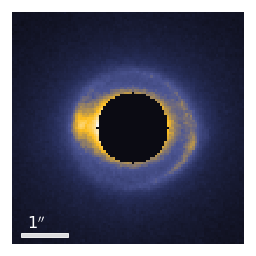

In [18]:
plt.imshow(dmap, extent=reconsrc.lensobject.extent, vmax=dmax, **plt_kw)
plot_scalebar(R=reconsrc.lensobject.maprad, length=1)
plt.axis('off')
plt.gcf().axes[0].get_xaxis().set_visible(False)
plt.gcf().axes[0].get_yaxis().set_visible(False)
# plt.colorbar()
# savename = "{}_data{}".format(name, extension)
# plt.savefig(savedir+savename, bbox_inches='tight')
# plt.close()


In [8]:
# chi2 = run_model(reconsrc, angle=angle, **kw)
chi2, maps = run_model(reconsrc, angle=angle, output_maps=True, **kw)
srcplane, synth, resids, _ = maps


In [11]:
print("Chi2 = {:8.4f}".format(chi2))


Chi2 =   1.6621


## Plotting

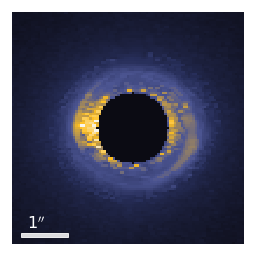

In [19]:
plt.imshow(synth, extent=reconsrc.lensobject.extent, vmax=dmax, **plt_kw)
plot_scalebar(R=reconsrc.lensobject.maprad, length=1)
plt.axis('off')
plt.gcf().axes[0].get_xaxis().set_visible(False)
plt.gcf().axes[0].get_yaxis().set_visible(False)
# plt.colorbar()
# savename = "{}_data{}".format(name, extension)
# plt.savefig(savedir+savename, bbox_inches='tight')
# plt.close()


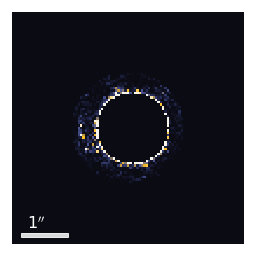

In [20]:
plt.imshow(resids, extent=reconsrc.lensobject.extent, vmax=0.01, **plt_kw)
plot_scalebar(R=reconsrc.lensobject.maprad, length=1)
plt.axis('off')
plt.gcf().axes[0].get_xaxis().set_visible(False)
plt.gcf().axes[0].get_yaxis().set_visible(False)
# plt.colorbar()
# savename = "{}_data{}".format(name, extension)
# plt.savefig(savedir+savename, bbox_inches='tight')
# plt.close()


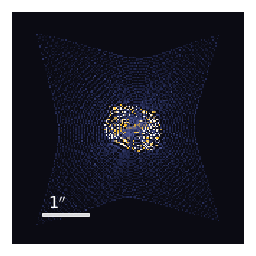

In [21]:
plt.imshow(srcplane, extent=reconsrc.lensobject.extent, vmax=smax, **plt_kw)
plot_scalebar(R=reconsrc.src_extent[1], length=1)
plt.axis('off')
plt.gcf().axes[0].get_xaxis().set_visible(False)
plt.gcf().axes[0].get_yaxis().set_visible(False)
# plt.colorbar()
# savename = "{}_data{}".format(name, extension)
# plt.savefig(savedir+savename, bbox_inches='tight')
# plt.close()
